<a href="https://colab.research.google.com/github/hungrynagini/movie_tag_prediction/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import json
import numpy as np
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

In [243]:
metadata = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ai/movies_metadata.csv')
keywords = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ai/keywords.csv')
plots = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ai/movie_plots.csv')
top_keywords = 40

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
def get_stop_words(stop_file_path,comma):
    """load stop words """
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        if comma:
            stopwords = f.readlines()[0].split(',')
        else:
            stopwords = f.readlines()
        print(len(stopwords))
        stop_set = set(m.strip().lower() for m in stopwords)
        return frozenset(stop_set)

def pre_process(text):
    # lowercase
    text=text.lower()
    #remove tags
    text=re.sub("<!--?.*?-->","",text)
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    return text

def try_load(row):
    try:
        jsonparse = json.loads(row)
        return jsonparse
    except Exception as e:
        return []

In [253]:
metadata

,id,title,Plot,length,keywords,kwords
0,11862,fatherofthebridepartii,The film begins five years after the events of...,5474,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","baby,midlife crisis,confidence,aging,daughter,..."
1,9087,theamericanpresident,Popular Democratic President Andrew Shepherd i...,5621,"[{'id': 833, 'name': 'white house'}, {'id': 84...","white house,usa president,new love,widower,wil..."
3,11517,moneytrain,"On Christmas, we meet foster brothers John and...",6768,"[{'id': 380, 'name': 'brother brother relation...","brother brother relationship,subway,new york c..."
4,11359,theindianinthecupboard,"On his ninth birthday, Omri receives an old cu...",8112,"[{'id': 1990, 'name': 'cupboard'}, {'id': 6186...","cupboard,games,puppet,parallel world,toy comes..."
5,12158,vampireinbrooklyn,An abandoned ship crashes into a dockyard in B...,6581,"[{'id': 3133, 'name': 'vampire'}, {'id': 3630,...","vampire,half vampire"
...,...,...,...,...,...,...
1606,24230,nemesis,"In the near future, illegal androids have beco...",5252,"[{'id': 679, 'name': 'cyborg'}]",cyborg
1607,302104,thatthingcalledtadhana,The film starts at an airport in Rome where Ma...,6086,"[{'id': 6895, 'name': 'philippines'}, {'id': 4...","philippines,destiny,pinoy"
1609,336890,goonlastoftheenforcers,"During a pro hockey lockout, Doug ""The Thug"" G...",5952,"[{'id': 6483, 'name': 'ice hockey'}]",ice hockey
1611,79927,thepopemustdie,The plot is predicated on the Vatican being co...,5624,"[{'id': 716, 'name': 'vatican'}, {'id': 717, '...","vatican,pope,priest,alternative comedy"


In [246]:
keywords

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...
46414,439050,"[{'id': 10703, 'name': 'tragic love'}]"
46415,111109,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46416,67758,[]
46417,227506,[]


In [0]:
plots = plots[['Release Year','Title','Plot']]
metadata = metadata[['original_title','title','overview','tagline','release_date','id']]
metadata = metadata.apply(lambda x: x[['title','overview','tagline','release_date','id']] if type(x['title']) != float else
                          x[['original_title','overview','tagline','release_date','id']],axis=1)
metadata = metadata.fillna('0000')
plots = plots.fillna('0000')
metadata.release_date = metadata.release_date.apply(lambda x: x[:4])
metadata.release_date = metadata.release_date.astype("int64")

In [0]:
plots = plots.rename(columns={"Title": "title", "Release Year": "release_date"})
metadata.title = metadata.title.apply(lambda x: ''.join(e for e in x if e.isalnum()).lower())
plots.title = plots.title.apply(lambda x: ''.join(e for e in x if e.isalnum()).lower())

In [249]:
metadata = metadata.merge(plots, how = 'left',on=['title', 'release_date'])
metadata.sort_values(by=['title'])
metadata = metadata.drop_duplicates(subset=["title", "release_date"])
metadata = metadata.fillna("")
metadata = metadata.replace("0000","")
metadata

,id,original_title,overview,release_date,tagline,title,Plot
0,862,,"Led by Woody, Andy's toys live happily in his ...",1995,,toystory,In a world where toys are living things who pr...
1,8844,,When siblings Judy and Peter discover an encha...,1995,Roll the dice and unleash the excitement!,jumanji,"In 1869, near Brantford, New Hampshire, two br..."
2,15602,,A family wedding reignites the ancient feud be...,1995,Still Yelling. Still Fighting. Still Ready for...,grumpieroldmen,The feud between Max (Walter Matthau) and John...
3,31357,,"Cheated on, mistreated and stepped on, the wom...",1995,Friends are the people who let you be yourself...,waitingtoexhale,"""Friends are the People who let you be yoursel..."
4,11862,,Just when George Banks has recovered from his ...,1995,Just When His World Is Back To Normal... He's ...,fatherofthebridepartii,The film begins five years after the events of...
...,...,...,...,...,...,...,...
45635,439050,,Rising and falling between a man and woman.,0,Rising and falling between a man and woman,subdue,
45636,111109,,An artist struggles to finish his work while a...,2011,,centuryofbirthing,
45637,67758,,"When one of her hits goes wrong, a professiona...",2003,A deadly game of wits.,betrayal,
45638,227506,,"In a small town live two brothers, one a minis...",1917,,satantriumphant,


In [250]:

metadata.Plot = metadata.Plot + metadata.overview + metadata.tagline
metadata = metadata.drop(['original_title','release_date','overview','tagline'],axis=1)
metadata.sort_values(by=['title'])
metadata['length'] = metadata.Plot.apply(lambda x: len(x))
metadata = metadata[metadata['length'] > 5200]
metadata

,id,title,Plot,length
4,11862,fatherofthebridepartii,The film begins five years after the events of...,5474
10,9087,theamericanpresident,Popular Democratic President Andrew Shepherd i...,5621
17,5,fourrooms,"The film is set on New Year's Eve, and starts ...",5717
19,11517,moneytrain,"On Christmas, we meet foster brothers John and...",6768
59,11359,theindianinthecupboard,"On his ninth birthday, Omri receives an old cu...",8112
...,...,...,...,...
44802,52960,thetamarindseed,An attractive British Home Office assistant na...,6319
44846,336890,goonlastoftheenforcers,"During a pro hockey lockout, Doug ""The Thug"" G...",5952
45128,269795,222,The movie starts with Dylan Branson (Michiel H...,9563
45542,79927,thepopemustdie,The plot is predicated on the Vatican being co...,5624


In [0]:
metadata.id = metadata.id.astype("int64")
metadata = metadata.merge(keywords,on=['id'])

In [0]:
# docs = metadata.Plot
# keywords = metadata.keywords
keyw = metadata.apply(lambda x: ",".join([i['name']
                          for i in try_load(x.keywords.replace("'","\""))]) if 
                                                         len(x) > 2 and type(x) != float else 0,axis=1)
metadata = metadata.assign(kwords=keyw.values)
metadata = metadata[metadata.kwords != '']

In [254]:
vector = CountVectorizer(tokenizer=lambda x: x.split(","))
tags = vector.fit_transform(metadata['kwords'])
print(tags.shape[1])
tag = vector.get_feature_names()
print(tag[:50])
n = tags.sum(axis=0).A1
result = dict(zip(tag,n))
print(result)
res = pd.DataFrame(list(result.items()),columns=['tag','count'])
res = res.sort_values(['count'],ascending=False)
tag_c = res['count'].values
real_tags = res.values[:500]
metadata = metadata.drop(['keywords'],axis=1)
for i in real_tags:
  metadata[i[0]] = metadata.kwords.apply(lambda x: 1 if i[0] in x else 0) 
print(real_tags)

4326
['', '17th century', '18th century', '1910s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '19th century', '21st century', '3d', 'abandoned house', 'abandoned mine', 'aboriginal', 'aborigine', 'absurdism', 'abuse', 'abusive father', 'abusive husband', 'abusive marriage', 'acapella', 'accident', 'acid', 'activist', 'actor', 'actress', 'adaptation', 'addicted', 'addiction', 'admiral', 'adolf hitler', 'adopted child', 'adoption', 'adoptive father', 'adult', 'adult animation', 'adulteress', 'adultery', 'advancement', 'adventure', 'adversary', 'advertising', 'aerial combat', 'affair', 'affection', 'afghanistan', 'africa']
{'': 5, '17th century': 1, '18th century': 3, '1910s': 3, '1930s': 1, '1940s': 2, '1950s': 2, '1960s': 3, '1970s': 10, '1980s': 1, '1990s': 1, '19th century': 8, '21st century': 1, '3d': 21, 'abandoned house': 1, 'abandoned mine': 1, 'aboriginal': 1, 'aborigine': 2, 'absurdism': 1, 'abuse': 2, 'abusive father': 1, 'abusive husband': 1, 'abusive marri

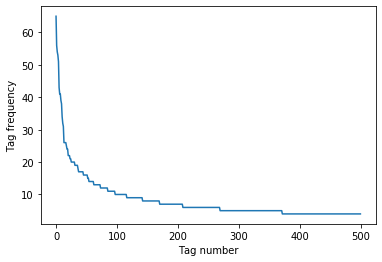

In [255]:
plt.plot(tag_c[:500])
plt.xlabel("Tag number")
plt.ylabel("Tag frequency")
plt.show()

318     81
161     31
466     30
1322    29
622     29
        ..
1357     1
731      1
735      1
1271     1
1113     1
Name: tag_count, Length: 1372, dtype: int64


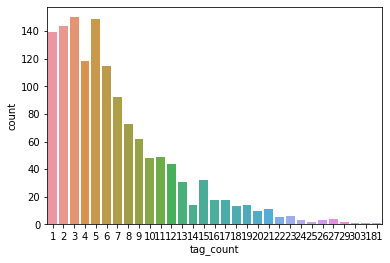

In [256]:
import seaborn as sns
metadata['tag_count'] = metadata.kwords.apply(lambda x: len(x.split(',')))
print(metadata.tag_count.sort_values(ascending=False))
sns.countplot(x=metadata['tag_count'],data=metadata)

In [0]:
movies = metadata.title.values
plots_ = metadata.Plot.values

In [257]:
#load a set of stop words
names=get_stop_words("/content/drive/My Drive/Colab Notebooks/ai/stop.txt",True)
surnames=get_stop_words("/content/drive/My Drive/Colab Notebooks/ai/us.txt",False)
my_stop_words = text.ENGLISH_STOP_WORDS.union(names)
my_stop_words = text.ENGLISH_STOP_WORDS.union(surnames)
print(names)
docs = metadata.Plot
ids = metadata.id.values
kwords = metadata.kwords.values

5631
88799
frozenset({'annamae', 'verda', 'jasmine', 'mathew', 'theodore', 'does', 'dorine', 'roseanne', 'garrett', 'catheryn', 'felecia', 'millie', 'golda', 'aida', 'krysten', 'olene', 'giuseppina', 'maye', 'kymberly', 'yoshie', 'temika', 'melba', 'providencia', 'roseanna', 'adelle', 'answered', 'kyra', 'lauran', 'delia', 'johanna', 'corina', 'denese', 'rena', 'eleonore', 'juanita', 'deangelo', 'julissa', 'echo', 'candy', 'annabel', 'shera', 'issac', 'further', 'went', 'sacha', 'lissette', 'libbie', 'evalyn', 'alicia', 'normand', 'inocencia', 'daina', 'antonette', 'nida', 'mirna', 'jack', 'about', 'isidro', 'arden', 'kennith', 'whereafter', 'shaina', 'matt', 'shae', 'lisette', 'myriam', 'great', 'elke', 'darcel', 'delicia', 'towanda', 'evette', 'shala', 'mandi', 'laurel', 'calvin', 'sibyl', 'janiece', 'lynell', 'candida', 'ron', 'cierra', 'shanti', 'louisa', 'lorraine', 'kellye', 'someone', 'arnoldo', 'two', 'goldie', 'jonie', 'shannon', 'dannie', 'janay', 'kendall', 'johnna', 'fawn',

In [194]:
metadata

,id,title,Plot,length,kwords,murder,independent film,duringcreditsstinger,woman director,based on novel,suspense,revenge,sequel,violence,musical,sport,world war ii,dystopia,aftercreditsstinger,blood,police,alien,london england,sex,teenager,escape,los angeles,love,3d,biography,monster,bollywood,magic,martial arts,friendship,serial killer,small town,remake,scientist,detective,...,sitting on a toilet,scotland,american,science,running,mirror,outlaw,orphanage,breakdance,surveillance,apocalypse,corpse,gritty,grief,organized crime,court,romance,mockumentary,cowardliness,girl,funeral,white house,crush,animation,wife,sadistic,strip club,general,android,ancient greece,gangster boss,storm,wish,stop motion,movie star,prequel,career,mars,male female relationship,tag_count
0,11862,fatherofthebridepartii,The film begins five years after the events of...,5474,"baby,midlife crisis,confidence,aging,daughter,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9
1,9087,theamericanpresident,Popular Democratic President Andrew Shepherd i...,5621,"white house,usa president,new love,widower,wil...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
3,11517,moneytrain,"On Christmas, we meet foster brothers John and...",6768,"brother brother relationship,subway,new york c...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
4,11359,theindianinthecupboard,"On his ninth birthday, Omri receives an old cu...",8112,"cupboard,games,puppet,parallel world,toy comes...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
5,12158,vampireinbrooklyn,An abandoned ship crashes into a dockyard in B...,6581,"vampire,half vampire",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,24230,nemesis,"In the near future, illegal androids have beco...",5252,cyborg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1607,302104,thatthingcalledtadhana,The film starts at an airport in Rome where Ma...,6086,"philippines,destiny,pinoy",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
1609,336890,goonlastoftheenforcers,"During a pro hockey lockout, Doug ""The Thug"" G...",5952,ice hockey,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1611,79927,thepopemustdie,The plot is predicated on the Vatican being co...,5624,"vatican,pope,priest,alternative comedy",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


In [0]:
real_tags[0] = [real_tags[0][0], real_tags[0][1]]
for tag in range(len(real_tags)):
  if type(real_tags[tag][0]) != str:
    real_tags[tag] = real_tags[tag][0]
  # print(tag[0], type(tag[0]))

In [259]:
from sklearn.feature_extraction.text import TfidfVectorizer 
# settings that you use for count vectorizer will go here
# tfidf_vectorizer=TfidfVectorizer(use_idf=True,stop_words=my_stop_words,ngram_range=(1,2))
tfidf_vectorizer=TfidfVectorizer(use_idf=True,stop_words=my_stop_words,min_df=20,ngram_range=(1,2))
# just send in all your docs here
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(docs)
feature_names = tfidf_vectorizer.get_feature_names()

print(feature_names[:50])
n_ = tfidf_vectorizer_vectors.sum(axis=0).A1
result_ = dict(zip(feature_names,n_))
words_probabil = pd.DataFrame(list(result_.items()),columns=['word','count'])
print(words_probabil.sort_values(by=['count']))


['00', '000', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '20', '200', '22', '24', '25', '30', '40', '50', '500', 'abandon', 'abandoned', 'abandoning', 'abandons', 'abducted', 'abilities', 'ability', 'aboard', 'abruptly', 'absence', 'absent', 'abuse', 'abusive', 'academy', 'accept', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accident', 'accidental', 'accidentally', 'accompanied', 'accompanies', 'accompany', 'accompanying', 'according', 'accosted']
              word      count
1143  enlists help   1.170302
3232         tying   1.215995
1294        feigns   1.221619
1120      enabling   1.230262
643      commotion   1.252818
...            ...        ...
3139          time  34.110009
1267        family  34.385412
1993        mother  35.896814
1278        father  46.262596
3074         tells  49.965763

[3422 rows x 2 columns]


In [260]:
metadata

,id,title,Plot,length,kwords,murder,independent film,duringcreditsstinger,woman director,based on novel,suspense,revenge,sequel,violence,musical,sport,world war ii,dystopia,aftercreditsstinger,blood,police,alien,london england,sex,teenager,escape,los angeles,love,3d,biography,monster,bollywood,magic,martial arts,friendship,serial killer,small town,remake,scientist,detective,...,sitting on a toilet,scotland,american,science,running,mirror,outlaw,orphanage,breakdance,surveillance,apocalypse,corpse,gritty,grief,organized crime,court,romance,mockumentary,cowardliness,girl,funeral,white house,crush,animation,wife,sadistic,strip club,general,android,ancient greece,gangster boss,storm,wish,stop motion,movie star,prequel,career,mars,male female relationship,tag_count
0,11862,fatherofthebridepartii,The film begins five years after the events of...,5474,"baby,midlife crisis,confidence,aging,daughter,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9
1,9087,theamericanpresident,Popular Democratic President Andrew Shepherd i...,5621,"white house,usa president,new love,widower,wil...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
3,11517,moneytrain,"On Christmas, we meet foster brothers John and...",6768,"brother brother relationship,subway,new york c...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
4,11359,theindianinthecupboard,"On his ninth birthday, Omri receives an old cu...",8112,"cupboard,games,puppet,parallel world,toy comes...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
5,12158,vampireinbrooklyn,An abandoned ship crashes into a dockyard in B...,6581,"vampire,half vampire",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,24230,nemesis,"In the near future, illegal androids have beco...",5252,cyborg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1607,302104,thatthingcalledtadhana,The film starts at an airport in Rome where Ma...,6086,"philippines,destiny,pinoy",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
1609,336890,goonlastoftheenforcers,"During a pro hockey lockout, Doug ""The Thug"" G...",5952,ice hockey,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1611,79927,thepopemustdie,The plot is predicated on the Vatican being co...,5624,"vatican,pope,priest,alternative comedy",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


In [0]:
#  for i in range(leng):
#   for tag in kwords[i].split(","):
#     print(tag)

In [0]:
top_keywords = 30
c = 0
probability = pd.DataFrame(columns=['tag','keyword','probability'])
leng = tfidf_vectorizer_vectors.shape[0]
for i in range(leng):
  first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[i]
# place tf-idf values in a pandas data frame
  df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=feature_names, columns=["tfidf"])
  vals = df.sort_values(by=["tfidf"],ascending=False).index
  leng_ = len(vals)
  if leng_ <= top_keywords:
    top_keywords = leng_
  vals = vals[:top_keywords]
  for tag in kwords[i].split(","):
    if tag in vals: 
      for val in vals:
        c += 1
        if ((probability['tag'] == tag) & (probability['keyword'] == val)).any():
          probability.loc[(probability['tag'] == tag) & (probability['keyword'] == val),'probability'] += 1
        else:
          probability = probability.append({'tag': tag, 'keyword': val, 'probability': 1}, ignore_index=True)
  metadata.loc[metadata['id'] == ids[i],'potential_kwords'] = ','.join(vals)

In [262]:
probability = probability.loc[probability['keyword'] != probability['tag']]
probability

,tag,keyword,probability
0,baby,annie,1
2,baby,basketball,1
3,baby,pregnant,3
4,baby,gives birth,1
5,baby,mr,1
...,...,...,...
19085,spirit,lifetime,1
19086,spirit,regularly,1
19087,spirit,misunderstanding,1
19088,spirit,sadness,1


In [0]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    return results

In [0]:
for j in range(25,40):
  print("\n",movies[j])
  # print(plots_[j])
  print(kwords[j])
  first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[j]
  sorted_items=sort_coo(first_vector_tfidfvectorizer.tocoo())
  keywords=extract_topn_from_vector(feature_names,sorted_items,30)
  potential = {}
  for tag in set(probability.tag.values):
    for keyw in keywords:
      val = probability[(probability['tag'] == tag) & (probability['keyword'] == keyw)]['probability']
      if not val.empty:
        if tag in potential:
          potential[tag] += val.values[0]/words_probabil[words_probabil['word'] == keyw]['count'].values[0]
        else:
          potential[tag] = val.values[0]/words_probabil[words_probabil['word'] == keyw]['count'].values[0]
  pot = sorted(potential.items(), key=lambda item: item[1],reverse=True)[:30]
  print(pot)
  j_ = kwords[j].split(",")
  for i in pot:
    if i[0] in j_:
      print(i[0])



 bodysnatchers
distrust,military base,remake,alien,escape,soldier,alien invasion,alien infection,sleeping,doppelganger,emotionless
[('alien', 4.797798866296952), ('moscow', 2.0962128072471398), ('escape', 1.984360034943963), ('drug', 1.6710754400561274), ('prison', 1.6679612900765624), ('marriage', 1.542993081815857), ('hotel', 1.5130390240155704), ('family', 1.4867429025971899), ('couple', 1.3649284358008407), ('murder', 1.3207268213159795), ('fbi', 1.0351089485570961), ('assassin', 1.0195468084312542), ('jungle', 0.9901528711574155), ('demon', 0.9146553953410747), ('planet', 0.9078418162023021), ('village', 0.8764991236169968), ('competition', 0.830302367227694), ('wilderness', 0.8118563717490829), ('retreat', 0.736948331135498), ('hometown', 0.736948331135498), ('weekend', 0.736948331135498), ('journalist', 0.736948331135498), ('subway', 0.736948331135498), ('poker', 0.7168336367681309), ('game', 0.6982173655010452), ('government', 0.6982173655010452), ('cup', 0.6982173655010452), 

In [279]:
potential

{'accident': 766    0.078079
 Name: count, dtype: float64, 'actor': 766    0.078079
 Name: count, dtype: float64, 'actress': 2763    0.334775
 Name: count, dtype: float64, 'affair': 1472   NaN
 Name: count, dtype: float64, 'air': 2328    0.077006
 Name: count, dtype: float64, 'alien': 1472   NaN
 Name: count, dtype: float64, 'alternative': 33    0.279692
 Name: count, dtype: float64, 'anniversary': 766    0.078079
 Name: count, dtype: float64, 'apartment': 2328    0.077006
 Name: count, dtype: float64, 'architect': 3311    0.200114
 Name: count, dtype: float64, 'assassin': 2009   NaN
 Name: count, dtype: float64, 'asylum': 518   NaN
 Name: count, dtype: float64, 'aunt': 1856    0.071862
 Name: count, dtype: float64, 'bartender': 1950    0.180485
 Name: count, dtype: float64, 'baseball': 1472   NaN
 Name: count, dtype: float64, 'basketball': 33   NaN
 Name: count, dtype: float64, 'blackmail': 2009   NaN
 Name: count, dtype: float64, 'boat': 349    0.192748
 Name: count, dtype: float64, 

In [265]:
# # for tag in real_tags:
potential = {}
for tag in set(probability.tag.values):
  # print(tag,'t')
  for keyw in keywords:
    # print(keyw,'k')
    val = probability[(probability['tag'] == tag) & (probability['keyword'] == keyw)]['probability']
    # print(val)
    if not val.empty:
      if tag in potential:
        potential[tag] += val.values[0]
      else:
        potential[tag] = val.values[0]

pot = sorted(potential.items(), key=lambda item: item[1],reverse=True)
pot[:20]

[('alien', 16),
 ('submarine', 7),
 ('robot', 7),
 ('father', 6),
 ('marriage', 5),
 ('divorce', 5),
 ('computer', 5),
 ('monster', 5),
 ('princess', 5),
 ('family', 5),
 ('cia', 5),
 ('hostage', 4),
 ('planet', 4),
 ('japan', 4),
 ('electricity', 4),
 ('drug', 4),
 ('truck', 4),
 ('mission', 4),
 ('desert', 3),
 ('detective', 3)]

In [268]:
pot
for i in kwords[20].split(","):
  if i in pot:
    print("yay")

[('alien', 16),
 ('submarine', 7),
 ('robot', 7),
 ('father', 6),
 ('marriage', 5),
 ('divorce', 5),
 ('computer', 5),
 ('monster', 5),
 ('princess', 5),
 ('family', 5),
 ('cia', 5),
 ('hostage', 4),
 ('planet', 4),
 ('japan', 4),
 ('electricity', 4),
 ('drug', 4),
 ('truck', 4),
 ('mission', 4),
 ('desert', 3),
 ('detective', 3),
 ('escape', 3),
 ('terrorist', 3),
 ('witch', 3),
 ('baby', 3),
 ('revenge', 3),
 ('vacation', 3),
 ('teacher', 3),
 ('jungle', 3),
 ('japanese', 3),
 ('heaven', 3),
 ('texas', 3),
 ('sister', 3),
 ('california', 3),
 ('murder', 2),
 ('surveillance', 2),
 ('curse', 2),
 ('disaster', 2),
 ('death', 2),
 ('mercenary', 2),
 ('tournament', 2),
 ('radio', 2),
 ('university', 2),
 ('future', 2),
 ('orphan', 2),
 ('couple', 2),
 ('fishing', 2),
 ('vietnam', 2),
 ('hell', 2),
 ('undercover', 2),
 ('sex', 2),
 ('cabin', 2),
 ('birthday', 2),
 ('moscow', 2),
 ('circus', 2),
 ('substance', 2),
 ('spaceship', 2),
 ('nuclear', 2),
 ('widow', 2),
 ('skin', 2),
 ('uncle', 2

In [210]:
print("\n=====Doc=====")
print(docs[20])
print("\n===Keywords===")
for k in keywords:
    print(k,keywords[k])


=====Doc=====
An unnamed gunslinger known only as The Lady arrives at the Old West town of Redemption circa 1881, where she enters a single elimination gunfighting contest held by Redemption's ruthless mayor and former outlaw John Herod. She encounters the Blind Shoeshine Boy and the repulsive escaped convict named Scars, whose proposition she harshly rebuffs. That night in the saloon it is made clear that all contestants are free to indulge in whatever they want in town and the rules of the competition are explained: if a contestant is challenged they cannot refuse, each contestant must fight once a day, and the fight ends when a contestant yields or is dead. While there she meets Cort, a former Herod henchman turned preacher whom Herod has captured and forced to enter the contest. During her first night in town, The Lady saves Cort's life by shooting through the rope Herod's men had used to hang him. She drunkenly spends the night with "The Kid", a brash young man who runs a gun sto

In [204]:
keywordz = metadata.keywords
print(keywordz[20])

AttributeError: ignored

In [0]:
# pip freeze > requirements.txt
# for tag in real_tags:
  # print(tag[1])

In [0]:
# probability = pd.DataFrame(columns=['tag','keyword','probability','pair'])
# for tag in real_tags:
#   texts_with_tag = metadata[metadata[tag] == 1]['potential_kwords']
#   print(texts_with_tag)
#   for text in texts_with_tag:
#     for keyword in text.split(','):
#       if (probability['pair'] == tag+":"+keyword).any():
#         probability[probability['pair'] == tag+":"+keyword]['probability'] += 1
#       probability = probability.append({'tag': tag, 'keyword': keyword, 'probability': 1,'pair':tag+":"+keyword}, ignore_index=True)

# probability = pd.DataFrame(columns=['tag','keyword','probability','pair'])
for tag in real_tags:
  texts_with_tag = metadata[metadata[tag[0]] == 1]['potential_kwords']
  print(texts_with_tag)
  for text in texts_with_tag:
    for keyword in text.split(','):
      if (probability['pair'] == tag+":"+keyword).any():
        probability[probability['pair'] == tag+":"+keyword]['probability'] += 1
      # probability = probability.append({'tag': tag, 'keyword': keyword, 'probability': tag[1]*,'pair':tag+":"+keyword}, ignore_index=True)

for text in test:
  for keyword in text:
    for tag in real_tags:
      tag_occur = (probability[probability['pair'] == keyword+":"+tag]).any()
      if tag_occur:
        prob = tag_occur['probabil_keyw'] * tag
# poten_tags = []
# for movie in test:
#   for keyword in movie:
#     poten_tags += keyword_pairs.sort.get_top_15
# poten_tags = poten_tags.sort.get_top_20



In [0]:
probability

In [0]:
all_keywords = metadata.kwords
# print(all_keywords)
all_keywords = [j for i in all_keywords for j in i]
set_k = list(set(all_keywords))
count_k = [[i, all_keywords.count(i)] for i in set_k]
print(count_k)

In [0]:
count_k.sort(key=lambda x: x[1],reverse=True)
print(count_k)

In [0]:
print(len(all_keywords))
print(len(set_k))
print(len([i for i in count_k if i[1] <= 5]))